In [1]:
# Disable some console warnings
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
#import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
import math
import seaborn as sns
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, Activation
from qkeras import *

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv('data/oct4_MCwithQuantInputs/InputTrainSet.csv')
#df1

In [3]:
df2 = pd.read_csv('data/oct4_MCwithQuantInputs/labelsTrain.csv')
#df2

In [4]:
df3 = pd.read_csv('data/oct4_MCwithQuantInputs/InputTestSet.csv')
#df3

In [5]:
df4 = pd.read_csv('data/oct4_MCwithQuantInputs/labelsTest.csv')
#df4

In [6]:
X_train = df1.values
X_test = df3.values

y_train = df2.values
y_test = df4.values
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 0)

print('Trainig set shape         :', X_train.shape) 
print('Trainig set shape (labels):', y_train.shape)
print('Test set shape:           :', X_test.shape)
print('Test set shape (labels)   :', y_test.shape)


Trainig set shape         : (792776, 14)
Trainig set shape (labels): (792776, 1)
Test set shape:           : (198196, 14)
Test set shape (labels)   : (198196, 1)


In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [8]:
import math 
print('X_train: max=', np.max(X_train), ', log2(max)=', int(np.ceil(math.log2(np.abs(np.max(X_train))))), ', min=', np.min(X_train), ', log2(min)=', int(np.ceil(math.log2(np.abs(np.min(X_train))))))
print('X_test: max=', np.max(X_test), ', log2(max)=', int(np.ceil(math.log2(np.abs(np.max(X_test))))), ', min=', np.min(X_test), ', log2(min)=', int(np.ceil(math.log2(np.abs(np.min(X_test))))))

X_train: max= 82.59475188891943 , log2(max)= 7 , min= -1.7786952735737245 , log2(min)= 1
X_test: max= 64.1270155482582 , log2(max)= 7 , min= -1.7793005128381305 , log2(min)= 1


In [9]:
# prefix = ''
# def CreateQModel(shape, nb_classes):
#     x = x_in = Input(shape)
#     x = QDense(128,
#         kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
#         name="dense1")(x)
#     x = keras.layers.BatchNormalization()(x)
#     x = QActivation("quantized_relu(10,0)", name="relu1")(x)
#     x = QDense(3,
#         kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
#         name="dense2")(x)
#     x = Activation("softmax", name="softmax")(x)
#     model = Model(inputs=x_in, outputs=x)
#     return model

# Fold BatchNormalization in QDense
prefix = 'foldbatchnorm_'
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape)
    x = QDenseBatchnorm(128,
        kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense1")(x)
    x = QActivation("quantized_relu(10,0)", name="relu1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense2")(x)
    x = Activation("softmax", name="softmax")(x)
    model = Model(inputs=x_in, outputs=x)
    return model
    

model = CreateQModel(X_train.shape[1:], y_train.shape[-1])

model.compile(optimizer=Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
dense1 (QDenseBatchnorm)     (None, 128)               2433      
_________________________________________________________________
relu1 (QActivation)          (None, 128)               0         
_________________________________________________________________
dense2 (QDense)              (None, 3)                 387       
_________________________________________________________________
softmax (Activation)         (None, 3)                 0         
Total params: 2,820
Trainable params: 2,563
Non-trainable params: 257
_________________________________________________________________


In [10]:
model_file = 'model/qkeras_' + prefix + 'model.h5'

train_and_save = False
history = None
if train_and_save:
    es = EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

    history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=150, 
                    batch_size=1024,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=0)
    
    model.save(model_file)
    
co = {}
utils._add_supported_quantized_objects(co)
model = tf.keras.models.load_model(model_file, custom_objects=co)

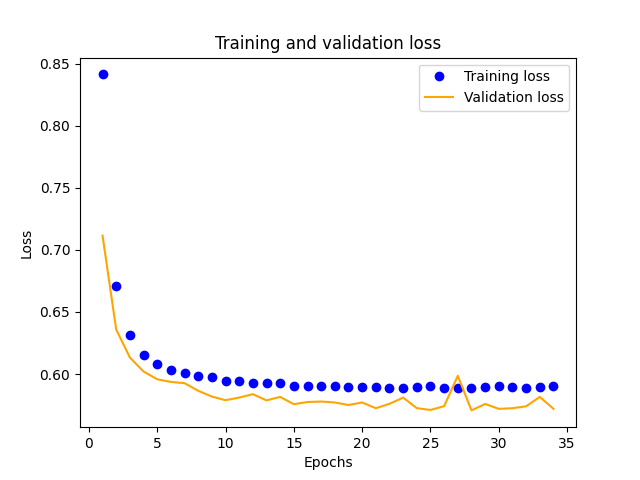

In [11]:
if train_and_save:
    history_dict = history.history
    loss_values = history_dict['loss'] 
    val_loss_values = history_dict['val_loss'] 
    epochs = range(1, len(loss_values) + 1) 
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/' + prefix + 'loss.png')
else:
    from PIL import Image

    img = Image.open('images/' + prefix + 'loss.png')
    display(img)

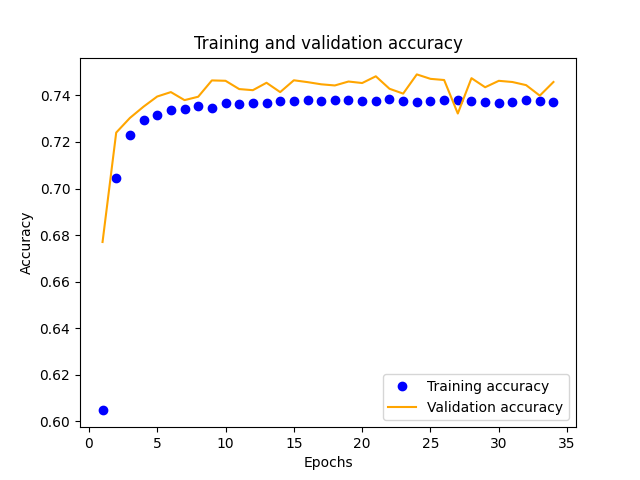

In [12]:
if train_and_save:
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    #np.max(val_acc)
    plt.savefig('images/' + prefix + 'accuracy.png')
    plt.show()
else:
    from PIL import Image
    #from os.path import exists

    img = Image.open('images/' + prefix + 'accuracy.png')
    display(img)

In [13]:
preds = model.predict(X_test) 
predictionsFiles = np.argmax(preds, axis=1)

In [14]:
pd.DataFrame(predictionsFiles).to_csv("csv/predictionsFiles.csv",header='predict', index=False)

In [15]:
pd.DataFrame(y_test).to_csv("csv/true.csv",header='true', index=False)

In [16]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.5649856925010681
Test accuracy: 0.7540717124938965


Confusion matrix:
[[80147  8858 10093]
 [15285 33822   442]
 [13955   109 35485]]


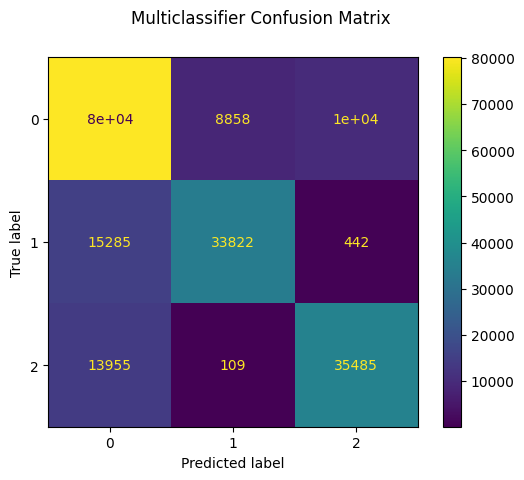

In [17]:
from sklearn import datasets, svm, metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig('images/' + prefix + 'confusionMatrix.png')
plt.show()

## hls4ml

In [18]:
import hls4ml
import plotting

/home/giuseppe/research/projects/fnal/CMS_PIX_28/hls4ml/hls4ml/converters/__init__.py:15: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [19]:
print('hls4ml ver.', hls4ml.__version__)

hls4ml ver. 0.5.1


In [20]:
import os
os.environ['PATH'] = '/opt/xilinx/Vivado/2019.1/bin:' + os.environ['PATH']
def is_tool(name):
    from distutils.spawn import find_executable
    return find_executable(name) is not None

print('-----------------------------------')
if not is_tool('vivado_hls'):
    print('Xilinx Vivado HLS is NOT in the PATH')
else:
    print('Xilinx Vivado HLS is in the PATH')
print('-----------------------------------')

-----------------------------------
Xilinx Vivado HLS is in the PATH
-----------------------------------


In [21]:
# hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
# hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
# hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

hls4ml.model.optimizer.get_optimizer('output_rounding_saturation_mode').configure(
    layers=['Activation'],
    rounding_mode='AP_RND_CONV',
    saturation_mode='AP_SAT')

hconfig = hls4ml.utils.config_from_keras_model(model, granularity='name')

# # hconfig['Model']['Precision'] = 'ap_fixed<16,6>'

# # # Input
# # hconfig['LayerName']['input_1']['Precision']['result'] = 'ap_fixed<16,8>'

# # # Dense
# # hconfig['LayerName']['dense1']['accum_t'] = 'ap_fixed<16,8>'
# # hconfig['LayerName']['dense1']['Precision']['result'] = 'ap_fixed<16,8>'

# # # Batch Normalization
# # hconfig['LayerName']['batch_normalization']['Precision']['scale'] = 'ap_fixed<16,8>'
# # hconfig['LayerName']['batch_normalization']['Precision']['bias'] = 'ap_fixed<16,8>'
# # hconfig['LayerName']['batch_normalization']['Precision']['result'] = 'ap_fixed<16,8>'

# # # ReLU
# # # hconfig['LayerName']['relu1']['Precision']['result'] = 'ap_fixed<10,0>'

# # # Dense
# # hconfig['LayerName']['dense2']['accum_t'] = 'ap_fixed<16,8>'
# # hconfig['LayerName']['dense2']['Precision']['result'] = 'ap_fixed<16,8>'

# # SoftMax
# #hconfig['LayerName']['softmax']['Precision'] = 'ap_fixed<128,64>'
hconfig['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
hconfig['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'

# Required for the folding of BatchNormalization
hconfig['SkipOptimizers'] = ['relu_merge']

# for layer in hconfig['LayerName'].keys():
#     hconfig['LayerName'][layer]['Trace'] = True

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense1, layer type: QDenseBatchnorm
  -> Activation (linear), layer name: dense1
Layer name: relu1, layer type: QActivation
  -> Activation (quantized_relu(10,0)), layer name: relu1
Layer name: dense2, layer type: QDense
  -> Activation (linear), layer name: dense2
Layer name: softmax, layer type: Activation


In [22]:
plotting.print_dict(hconfig)

Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
LayerName
  input_1
    Precision
      result:        ap_fixed<16,6>
  dense1
    Precision
      weight:        ap_fixed<5,1>
      bias:          ap_fixed<5,1>
    ReuseFactor:     1
  dense1_linear
    Precision:       ap_fixed<16,6>
    ReuseFactor:     1
    table_size:      1024
    table_t:         ap_fixed<18,8>
  relu1
    Precision
      result:        ap_ufixed<10,0>
    ReuseFactor:     1
  relu1_quantized_relu(10,0)
    Precision:       ap_fixed<16,6>
    ReuseFactor:     1
    table_size:      1024
    table_t:         ap_fixed<18,8>
  dense2
    Precision
      weight:        ap_fixed<5,1>
      bias:          ap_fixed<5,1>
    ReuseFactor:     1
  dense2_linear
    Precision:       ap_fixed<16,6>
    ReuseFactor:     1
    table_size:      1024
    table_t:         ap_fixed<18,8>
  softmax
    Precision:       ap_fixed<16,6>
    ReuseFactor:     1
    table_size:      1024
   

In [28]:
hmodel = hls4ml.converters.convert_from_keras_model(model,
                                                    hls_config=hconfig,
                                                    backend='VivadoAccelerator',
                                                    output_dir='hls4ml_prj',
                                                    part='XC7A100T')

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 14]], output shape: [None, 14]
Layer name: dense1, layer type: QDenseBatchnorm, input shapes: [[None, 14]], output shape: [None, 128]
Layer name: relu1, layer type: Activation, input shapes: [[None, 128]], output shape: [None, 128]
Layer name: dense2, layer type: QDense, input shapes: [[None, 128]], output shape: [None, 3]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 3]], output shape: [None, 3]
Creating HLS model


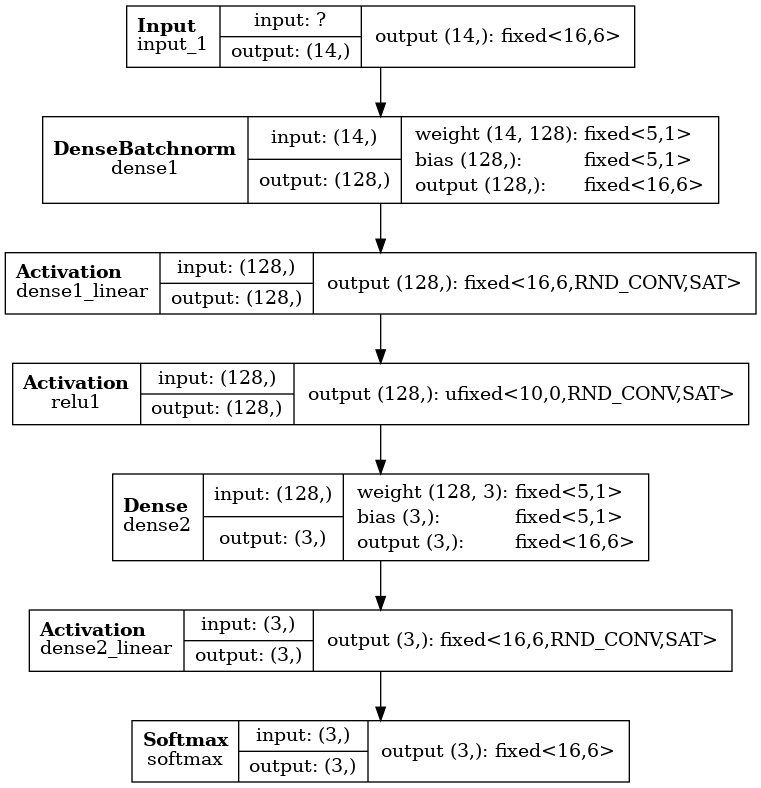

In [29]:
hls4ml.utils.plot_model(hmodel, show_shapes=True, show_precision=True, to_file=None)

In [30]:
hpreds, htrace = hmodel.trace(np.ascontiguousarray(X_test))

Recompiling myproject with tracing
Writing HLS project
Done


firmware/myproject_axi.cpp: In function ‘void myproject_axi(input_axi_t*, output_axi_t*)’:
firmware/myproject_axi.cpp:21:54: error: ‘w2’ was not declared in this scope
   21 |         nnet::load_weights_from_txt<weight2_t, 1792>(w2, "w2.txt");
      |                                                      ^~
firmware/myproject_axi.cpp:22:51: error: ‘b2’ was not declared in this scope
   22 |         nnet::load_weights_from_txt<bias2_t, 128>(b2, "b2.txt");
      |                                                   ^~
firmware/myproject_axi.cpp:23:53: error: ‘w5’ was not declared in this scope
   23 |         nnet::load_weights_from_txt<weight5_t, 384>(w5, "w5.txt");
      |                                                     ^~
firmware/myproject_axi.cpp:24:49: error: ‘b5’ was not declared in this scope
   24 |         nnet::load_weights_from_txt<bias5_t, 3>(b5, "b5.txt");
      |                                                 ^~
/usr/bin/ld: cannot find myproject_axi.o: No such file or d

OSError: hls4ml_prj/firmware/myproject-b0BC5Fbb.so: cannot open shared object file: No such file or directory

In [26]:
print(htrace)

{}


In [ ]:
trace = hls4ml.model.profiling.get_ymodel_keras(model, X_test)

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

In [ ]:
for layer in htrace.keys():
    plt.figure()
    klayer = layer
    if '_alpha' in layer:
        klayer = layer.replace('_alpha', '')
    plt.scatter(htrace[layer].flatten(), trace[klayer].flatten(), s=0.2)
    min_x = min(np.amin(htrace[layer]), np.amin(trace[klayer]))
    max_x = max(np.amax(htrace[layer]), np.amax(trace[klayer]))
    plt.plot([min_x, max_x], [min_x, max_x], c='gray')
    plt.xlabel('hls4ml {}'.format(layer))
    plt.ylabel('QKeras {}'.format(klayer))
    plt.savefig(os.path.join('hls4ml_prj', prefix + 'profiling_{}.png'.format(layer)), dpi=300)

In [ ]:
for layer in hconfig['LayerName'].keys():
    hconfig['LayerName'][layer]['Trace'] = False

hmodel = hls4ml.converters.convert_from_keras_model(model,
                                                    backend='VivadoAccelerator',
                                                    hls_config=hconfig,
                                                    output_dir='hls4ml_prj',
                                                    part='XC7A100T')

hmodel.compile()

In [ ]:
hpreds = hmodel.predict(np.ascontiguousarray(X_test)) 

In [ ]:
from sklearn.metrics import accuracy_score
print('-----------------------------------')
print("QKeras accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(preds, axis=1))))
print("hls4ml accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(hpreds, axis=1))))
print('-----------------------------------')


In [ ]:
%%time
results = hmodel.build(csim=False)

In [ ]:
print('-----------------------------------')
#print(results) # Print hashmap
hls_results=results
#['CSynthesisReport'] 
#print("Estimated Clock Period: {} ns".format(hls_results['EstimatedClockPeriod']))
print("Best/Worst Latency:     {} / {}".format(hls_results['BestLatency'], hls_results['WorstLatency']))
print("Interval Min/Max:       {} / {}".format(hls_results['IntervalMin'], hls_results['IntervalMax']))
print("BRAM_18K:               {}, {:0.1f}% (Aval. {})".format(hls_results['BRAM_18K'], int(hls_results['BRAM_18K'])*100.0/int(hls_results['AvailableBRAM_18K']), hls_results['AvailableBRAM_18K']))
print("DSP48E:                 {}, {:0.1f}% (Aval. {})".format(hls_results['DSP48E'], int(hls_results['DSP48E'])*100.0/int(hls_results['AvailableDSP48E']), hls_results['AvailableDSP48E']))
print("FF:                     {}, {:0.1f}% (Aval. {})".format(hls_results['FF'], int(hls_results['FF'])*100.0/int(hls_results['AvailableFF']), hls_results['AvailableFF']))
print("LUT:                    {}, {:0.1f}% (Aval. {})".format(hls_results['LUT'], int(hls_results['LUT'])*100.0/int(hls_results['AvailableLUT']), hls_results['AvailableLUT']))
#print("URAM:                   {}, {} (Aval. {})".format(hls_results['URAM'], int(hls_results['URAM'])*100.0/int(hls_results['AvailableURAM']), hls_results['AvailableURAM']))
print('-----------------------------------')